# ISYE6444 Mini-Project 2: Implementing the Tausworthe Pseudorandom Number Generator

July 22, 2021

Ansel Lim

ansel@gatech.edu

**Abstract/Major Findings**

The Tausworthe pseudorandom number generator described in Module 6 of our class is implemented. Plots of adjacent pseudorandom numbers are created to check for autocorrelation patterns. Numerous statistical tests are performed to evaluate the pseudorandom numbers generated by the algorithm and show that these deviates are approximately i.i.d. Uniform(0,1). Overall, the generator that was implemented performed well on goodness-of-fit tests (chi-squared and Kolmogorov-Smirnov) and runs tests, but did not perform that well on autocorrelation tests; this suggests that the sequence of PRNs exhibits satisfactory global behavior but shows erratic local behavior. Finally, the pseudorandom numbers generated by the algorithm are used to generate standard normal deviates.

## Introduction

Generation of uniform pseudorandom numbers (PRNs) is at the heart of simulation. Various methods for generating PRNs exist. Examples include linear congruential generators, feedback shift register generators, Fibonacci generators, and combination generators.

As described in "Simulation Modeling and Analysis" (2015) by Averill Law, the Tausworthe pseudorandom number generator is an example of a *linear feedback shift register (LFSR)* generator. 

Here's how the Tausworthe generator works, as described by Law (2015). We construct a sequence of binary digits, $b_1, b_2, \cdots$, using the following recurrence (which may be reminiscent of multiple recursive generators): $$b_i = (c_i b_{i-1} + c_2 b_{i-2} + \cdots + c_q b_{i-q}) \pmod 2$$ where the coefficients $\{c_j\}_{j=1}^{j=q-1}$ are either 0 or 1 (note that $c_q=1$). The Tausworthe generator uses the last $q$ bits of the sequence, so the sequence of bits generated is an autoregressive sequence of order $q$.

In this mini-project, I will implement the Tausworthe generator.

## Implementation 0: rough, naive implementation of a poorly performing Tausworthe pseudorandom number generator

As a start, let's implement the example in the lecture slides. Law (2015) states that in most applications, only two of the $c_j$ coefficients (as in the equation above) are nonzero. In this case, the equation simplifies to $$b_i = (b_{i-r} + b_{i-q}) \pmod 2$$ for integers $r$ and $q$ such that $0<r<q$.

In the example generator, the initialization sequence is $B_1=\cdots= B_5 =1$. $r=3,q=5$. The recurrence relation is $B_i = (B_{i-3} + B_{i-5})\pmod 2 = B_{i-3} \bigoplus B_{i-5}$, $i>5$. The period of 0-1 bits is $2^q-1 = 2^5-1 = 31$.

In [1]:
# import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chisquare
from scipy.stats import kstest
from scipy.stats import norm
import re

In [2]:
# Helper function to convert binary to decimal
def BinaryToDecimal(binaryNumber):
    binaryNumber = str('0b') + str(binaryNumber)
    decimal = int(binaryNumber,2)
    return decimal

In [3]:
# Implement example given in Law (2015)
def Tausworthe1(r=3,q=5,l=4,num=50):
    
    '''
    Input parameters
    r=3
    q=5
    l=4 (how many bits you use to calculate the uniforms)
    num=50 (how many numbers you want to generate)
    '''
    
    r=3
    q=5
    b=np.ones(q,dtype=np.int32) #set initialization sequence to all 1's
    for i in range(q,l*num):
        new=np.logical_xor(b[i-r],b[i-q])
        b=np.append(b,new)
    unifs=[]
    for j in range(num):
        number= b[j*l:(j+1)*l]
        number=np.char.mod("%i",number)
        number="".join(number)
        number=BinaryToDecimal(number)
        denominator=2**l
        unif=number/denominator
        unifs.append(unif)
    return unifs

It's painfully obvious from a histogram of the PRNs generated that this generator is a really poor generator. The distribution of numbers does not resemble the uniform distribution.

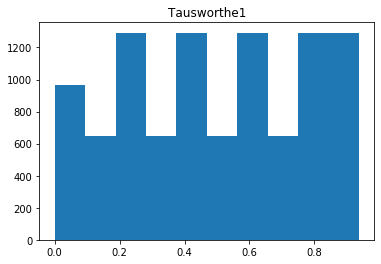

In [4]:
my_numbers = Tausworthe1(num=10000)
plt.hist(my_numbers)
plt.title('Tausworthe1')
plt.show()

There are a lot of repeat numbers generated. We can use the `Counter` function in the `collections` module of the Python standard library to enumerate how many of each unique number we observe.

In [5]:
Counter(my_numbers)

Counter({0.9375: 646,
         0.5: 646,
         0.8125: 646,
         0.25: 646,
         0.125: 645,
         0.3125: 645,
         0.5625: 645,
         0.0625: 645,
         0.6875: 646,
         0.625: 645,
         0.1875: 646,
         0.875: 645,
         0.4375: 644,
         0.0: 322,
         0.375: 644,
         0.75: 644})

I won't do statistical tests to check the uniformity and independence of these PRNs, because it's patently clear from the visualization and the many repeated deviates--even without resorting to statistical tests--that this is a pretty lousy generator. So, let's focus our efforts on making a better generator.

## Implementation 1: using a primitive polynomial of order 24

The Wikipedia article on linear-feedback shift registers (https://en.wikipedia.org/wiki/Linear-feedback_shift_register#Example_polynomials_for_maximal_LFSRs) has a table of primitive polynomials for shfit-register lengths up to 24. 

Let's use the order-24 feedback polynomial $x^{24}+x^{23}+x^{22}+x^{17}+1$, which 'translates' into $b_{n+24} + b_{n+23} + b_{n+22} + b_{n+17} + b_n=0 \pmod{2}$, for $n=0,1,2,\cdots$. This is equivalent to writing $b_{n+24}+b_{n+23}+b_{n+22}+b_{n+17}+b_n=0 \pmod{2}$, for $n=0,1,2,\cdots$.

Making the appropriate substitution, this is equivalent to $b_n = b_{n-1} \bigoplus b_{n-2} \bigoplus b_{n-7} \bigoplus b_{n-24}$ ($n=24,25,26,\cdots$) where $\bigoplus$ is the XOR operator. This feedback polynomial should give a period of $2^{24}-1=16777215$.

Reference: I followed an example for a different primitive polynomial, $x^7+x^3+1$, given in a set of lecture notes from Washington University in St. Louis (https://www.cse.wustl.edu/~jain/iucee/ftp/k_26rng.pdf), to translate the order-24 feedback polynomial I found on Wikipedia.

In [6]:
# Use the polynomial described previously to make another Tausworthe generator
def Tausworthe2(l=30,num=100):
    assert (num>6), "Use num > 6"
    b=np.array(list(map(int,list('111000010000000000000000'))))
    for i in range(24,l*num):
        new= np.logical_xor(np.logical_xor(b[i-1],b[i-2]),np.logical_xor(b[i-7],b[i-24]), )
        b=np.append(b,new)
    unifs=[]
    for j in range(num):
        number= b[j*l:(j+1)*l]
        number=np.char.mod("%i",number)
        number="".join(number)
        number=BinaryToDecimal(number)
        denominator=2**l
        unif=number/denominator
        unifs.append(unif)
    return np.array(unifs)

In [7]:
NUM_OF_RANDOMS = 20000
my_numbers=Tausworthe2(l=40,num=NUM_OF_RANDOMS)

In [8]:
my_numbers_1=my_numbers[:int(NUM_OF_RANDOMS/2)]
my_numbers_2=my_numbers[int(NUM_OF_RANDOMS/2):]

The histogram shows a much more satisfying distribution that approximates the uniform distribution fairly well.

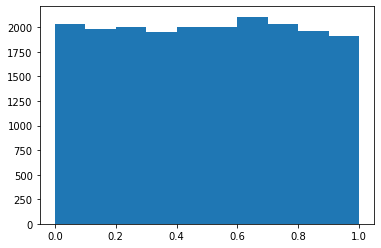

In [9]:
plt.hist(my_numbers)
plt.show()

We can verify that none of the numbers are repeated.

In [10]:
len(set(my_numbers))==len(my_numbers)

True

Let's plot adjacent PRN’s $(U_i, U_{i+1})$ ($i = 1, 2, \cdots$) on the unit square to see if there are any patterns. There do not appear to be any patterns in the unit square, so it seems our generator is doing well.

In [11]:
def PlotAdjacentPseudos(uniforms):
    x=np.array([],dtype=np.float64)
    y=np.array([],dtype=np.float64)
    for i in range(len(uniforms)-1):
        U_i = uniforms[i]
        U_j = uniforms[i+1]
        x=np.append(x,U_i)
        y=np.append(y,U_j)
    plt.scatter(x,y)
    plt.title('Adjacent pseudorandom numbers')
    plt.show()

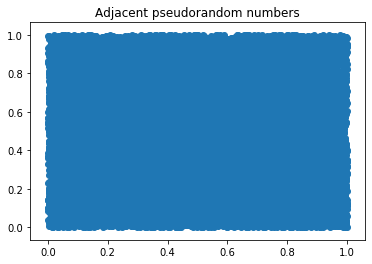

In [12]:
PlotAdjacentPseudos(my_numbers)

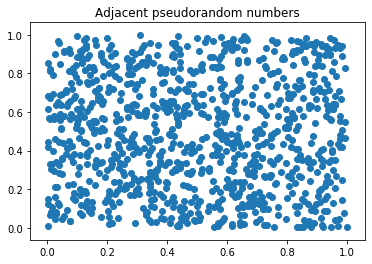

In [13]:
#run with a smaller subset, so we can appreciate the randomness
PlotAdjacentPseudos(my_numbers[:1000])

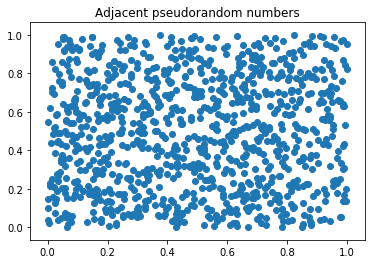

In [14]:
#run with a smaller subset, so we can appreciate the randomness
PlotAdjacentPseudos(my_numbers[1000:2000])

## Assessing Implementation 1

Now, let's run the following empirical tests to determine how closely our PRNs resemble i.i.d. Uniform(0,1) random variables.

1. Test of Uniformity: Chi-squared goodness-of-fit testing
2. Test of Uniformity: Kolmogorov-Smirnov test for goodness of fit
3. Test of Independence: runs up and down
4. Test of Independence: runs above and below the mean
5. Test of Autocorrelation: autocorrelation (lag-1 correlation)

## (One-dimensional) Chi-Squared Goodness-of-Fit Testing

We follow the approach described in the lecture notes for testing whether a sequence of pseudorandoms $R_1,R_2,\cdots,R_n$ is approximately Uniform.

1. Divide the unit interval into $k$ cells (subintervals)
2. Tally how many of the $n$ observations fall into the $k$ cells.
3. The number of observations in cell $i$ should follow the binomial distribution $\text{Binomial}(n,1/k)$. The expected number of observations in cell $i$ is $n/k$.
4. Perform a chi-squared goodness-of-fit test.

In [15]:
#bin observations into num_cells number of cells, to compute observed frequencies
def BinObservations(uniforms,num_cells):
    floors = [(i/num_cells) for i in range(0,num_cells)]
    ceilings=[ (i/num_cells) for i in range(1,num_cells+1)]
    frequencies=[]
    for j in range(num_cells):
        floor=floors[j]
        ceiling=ceilings[j]
        frequency=((uniforms>=floor) & (uniforms<ceiling)).sum()
        frequencies.append(frequency)
    return np.array(frequencies)

In [16]:
#chi-squared goodness-of-fit test
def GoodnessOfFit(uniforms,num_cells):
    num_uniforms=len(uniforms)
    expected = num_uniforms/num_cells
    assert ((expected>=5) and(num_uniforms>=30)), "Re-run code. Recommend expected>=5 and n>=30."
    observed_frequencies = BinObservations(uniforms,num_cells) 
    test_stat,p_value = chisquare(f_obs=observed_frequencies,f_exp=[expected]*num_cells)
    return (test_stat,p_value)

The p-value for the chi-squared GOF test is 0.16. We FAIL TO REJECT the null hypothesis $H_0$ (that the observations are uniform). 

In [17]:
test_statistic,p_value=GoodnessOfFit(my_numbers,10)
print(test_statistic,p_value)

13.062999999999999 0.15977623999805513


## Kolmogorov-Smirnov test for goodness of fit

The Kolmogorov-Smirnov test, which is based on the 'empirical distribution function' may be used to assess whether our sequence of PRNs palusibly comes from a population of deviates from the Uniform distribution.

Fail to reject the null hypothesis of normality.

In [18]:
test_statistic,p_value=kstest(my_numbers,'uniform')
print(test_statistic,p_value)

0.007357863474897752 0.2290331062674011


## Independence - Runs Up and Down

Let's perform a runs up and down test to evaluate the null hypothesis that the sequence $R_1,R_2,\cdots,R_n$ are independent. We use the amazing fact that (supposing $A$ is the total number of runs up and down) when $n$ is large and the PRNs are actually independent, then $$A\approx \text{Nor}[\frac{(2n-1)}{3},\frac{(16n-29)}{90}]$$ We reject the null hypothesis of independence if the (absolute value of the) test statistic exceeds a critical value that is defined by our choice of $\alpha$.

In [19]:
def RunsUpAndDown(uniforms,alpha=0.05):
    n=len(uniforms)
    runs=[]
    for i in range(n-1):
        if uniforms[i]<=uniforms[i+1]:
            runs.append('+')
        else:
            runs.append('-')
    runs2=''.join(runs)
    runs2=re.findall(r'\++|-+',runs2)
    num_of_runs=len(runs2)
    
    mean=(2*n-1)/3
    variance=(16*n-29)/90
    
    test_statistic = (num_of_runs-mean)/np.sqrt(variance)
    absolute_value_test_statistic = np.abs(test_statistic)
    critical_value = norm.ppf(1-alpha/2)
    if absolute_value_test_statistic>critical_value:
        result='Reject null hypothesis of independence'
    else:
        result='Fail to reject null hypothesis'
    return (num_of_runs,test_statistic,critical_value,result)

We fail to reject the null hypothesis of independence.

In [20]:
num_of_runs,test_statistic,critical_value,result=RunsUpAndDown(my_numbers)
print(num_of_runs,test_statistic,critical_value,result)

13347 0.23479777715281214 1.959963984540054 Fail to reject null hypothesis


## Independence - Runs Above and Below the Mean

Let's now perform a runs test "above and below the mean". If $B$ is the total number of runs, we know that if $n$ is large and the null hypothesis is true, then $B \approx \text{Nor}(2n_1n_2/n+0.5,2n_1n_2(2n_1n_2-n)/[n^2(n-1)])$ where $n_1$ is the number of observations above or equal to the mean (0.5), and $n_2=n-n_1$.

In [21]:
def RunsAboveAndBelowMean(uniforms,alpha=0.05):
    n=len(uniforms)
    runs=[]
    for i in range(n):
        if uniforms[i]>=0.5:
            runs.append('+')
        else:
            runs.append('-')
    runs2=''.join(runs)
    n1=runs2.count('+')
    n2=runs.count('-')
    runs3=re.findall(r'\++|-+',runs2)
    num_of_runs=len(runs3)
    
    mean=(2*n1*n2)/n + 0.5
    variance=2*n1*n2*(2*n1*n2-n)/((n*n)*(n-1))
    
    test_statistic = (num_of_runs-mean)/np.sqrt(variance)
    absolute_value_test_statistic = np.abs(test_statistic)
    critical_value = norm.ppf(1-alpha/2)
    if absolute_value_test_statistic>critical_value:
        result='Reject null hypothesis of independence'
    else:
        result='Fail to reject null hypothesis'
    return (num_of_runs,test_statistic,critical_value,result)

Fail to reject the null hypothesis of PRN independence.

In [22]:
num_of_runs,test_statistic,critical_value,result=RunsAboveAndBelowMean(my_numbers)
print(num_of_runs,test_statistic,critical_value,result)

9936 -0.9115708903744691 1.959963984540054 Fail to reject null hypothesis


## Independence - Autocorrelation test

Let's use the facts from the lecture notes to conduct a correlation test using the lag-1 correlation $$\rho \equiv \text{Corr}(R_i,R_{i+1})$$ The estimator is $$ \hat{\rho} = \frac{12}{n-1}( \sum_{k=1}^{n-1} R_k R_{k+1}) -3$$

Under the null hypothesis of independence, $$\hat{\rho} \approx \text{Nor}(0,(13n-19)/(n-1)^2)$$

Similar to the other statistical tests for independence we've already tried, we reject the null hypothesis if the absolute value of the test statistic exceeds the critical value.

In [23]:
## Autocorrelation test for independence

def Autocorrelation(uniforms,alpha=0.05):
    rho_estimate=0
    n=len(uniforms)
    for i in range(0,n-1):
        rho_estimate+=uniforms[i]*uniforms[i+1]
    rho_estimate*= 12/(n-1)
    rho_estimate-=3
    
    mean=0
    variance=(13*n-19)/((n-1)**2)
    
    test_statistic=(rho_estimate)/np.sqrt(variance)
    absolute_value_test_statistic=np.abs(test_statistic)/np.sqrt(variance)
    
    critical_value = norm.ppf(1-alpha/2)
    if absolute_value_test_statistic>critical_value:
        result='Reject null hypothesis of independence'
    else:
        result='Fail to reject null hypothesis'
    
    return (rho_estimate,test_statistic,critical_value,result)

The results of the autocorrelation test suggest that we should reject the null hypothesis of independence. It seems that while the Tausworthe generator performs well globally (it did well on both runs tests), the 'local behavior' of the generator may not be too good. This compares well with the literature about Tausworthe generator. For example, a set of lecture notes by John Mellor-Crummey of Rice University (https://www.cs.rice.edu/~johnmc/comp528/lecture-notes/Lecture21.pdf) suggests that one disadvantage of Tausworthe generators is that 'while sequence is good overall, local behavior may not be'. I interpret the relative poor performance of my generator on autocorrelation tests to be indicative of this pattern of poorer 'local' performance (relative to 'global' performance)

In [24]:
rho_estimate,test_statistic,critical_value,result=Autocorrelation(my_numbers)
print(rho_estimate,test_statistic,critical_value,result)

-0.011735679617318251 -0.4603050295372821 1.959963984540054 Reject null hypothesis of independence


## Standard Normal deviates

Let's generate some independently and identically distributed Normal deviates using the Box-Muller method.

In [25]:
def GenerateStandardNormals(uniforms1,uniforms2):
    Z1=np.sqrt(-2*np.log(uniforms1))*np.cos(2*np.pi*uniforms2)
    Z2=np.sqrt(-2*np.log(uniforms1))*np.sin(2*np.pi*uniforms2)
    return (Z1,Z2)

In [26]:
U1,U2=my_numbers_1,my_numbers_2
Z1,Z2=GenerateStandardNormals(U1,U2)

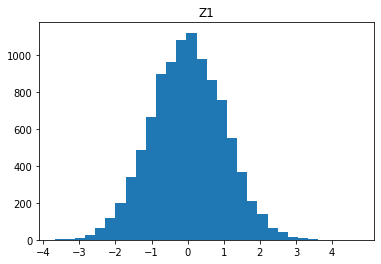

In [27]:
plt.hist(Z1,bins=30)
plt.title('Z1')
plt.xticks(np.arange(-4,5))
plt.show()

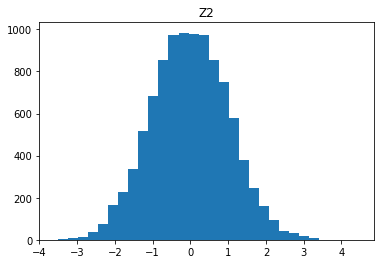

In [28]:
plt.hist(Z2,bins=30)
plt.title('Z2')
plt.xticks(np.arange(-4,5))
plt.show()

In [29]:
# We can check for normality of our deviates Z1 using the K-S test.
# p-value suggests we fail to reject null hypothesis.
# conclude that Z1 is approximately Normal.
test_statistic,p_value=kstest(Z1,'norm')
print(test_statistic,p_value)

0.008192790359958901 0.5131177179466404


**Findings/Conclusions**

1. Implementation 0 (the rough, naive implementation) of the Tausworthe generator performs poorly.
2. Implementation 1 of the Tausworthe generator, which used a primitive polynomial of order 24, performed well on chi-squared goodness of fit testing as well as runs tests (both runs up and down and runs above and below the mean). However, my implementation did not perform well locally -- it performed negatively on the autocorrelation (first-order serial correlation) test of independence.
3. The histograms of the standard normal deviates we generated (by applying the Box-Muller method on the PRNs generated by Implementation 1) appear satisfactory.
4. The empirical tests tell us only about how Implementation 1 performed on the segment of the cycle that was actually used to generate the PRNs. Only that segment of the cycle is examined, so the performance of the generator on, say, the first 20,000 PRNs may not necessarily generalize to how the generator performs on the next 80,000 PRNs. This is something mentioned in Law (2015)'s book: 'empirical tests are only local', and the test only evaluates the performance of the generator on part of the random number stream. One way to partially overcome this limitation is to run the empirical tests on multiple random-number streams, that is, to repeat these empirical tests multiple times.

In [30]:
# We can check for normality of our deviates Z2 using the K-S test.
test_statistic,p_value=kstest(Z2,'norm')
print(test_statistic,p_value)

0.015114954537308045 0.020731708346178677


## Additional work Part A

Robert C. Tausworthe's original paper, titled 'Random Numbers Generated by Linear Recurrence Modulo Two' (https://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0184406-1/S0025-5718-1965-0184406-1.pdf), actually provides a great deal of useful information that can be relied upon to realize implementations of the theory. The last two paragraphs suggests the use of a degree-35 polynomial $x^{35} + x^2 + 1$ with $l=35$. Let's try that.

In [31]:
# helper function to randomly generate binary string of length p
def BinaryString(p):
    string = ''
    for i in range(p):
        temp=str(np.random.randint(0,1+1))
        string+=temp
    return string

In [32]:
# x^35 + x^2 + 1
def Tausworthe3(l=35,num=100):
    b=np.array(list(map(int,list(BinaryString(35)))))
    for i in range(35,l*num):
        new= np.logical_xor(b[i-33],b[i-35])
        b=np.append(b,new)
    unifs=[]
    for j in range(num):
        number= b[j*l:(j+1)*l]
        number=np.char.mod("%i",number)
        number="".join(number)
        number=BinaryToDecimal(number)
        denominator=2**l
        unif=number/denominator
        unifs.append(unif)
    return np.array(unifs)

In [33]:
NUM_OF_RANDOMS=10000
additional_numbers = Tausworthe3(num=NUM_OF_RANDOMS)

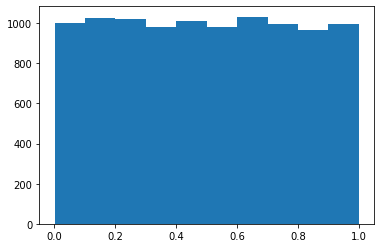

In [34]:
#histogram of PRNs
plt.hist(additional_numbers)
plt.show()

In [35]:
#check if PRNs are repeated
len(set(additional_numbers))==len(additional_numbers)

True

For some reason, the plot of adjacent PRNs on the unit square seems to resemble an 'M'. Not quite sure why. This indicates non-randomness.

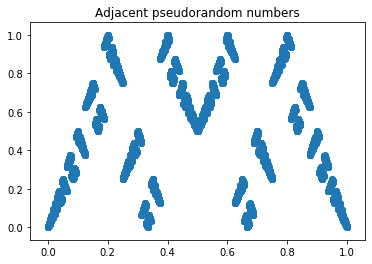

In [36]:
#plot adjacent PRNs on unit square to check for patterns
PlotAdjacentPseudos(additional_numbers)

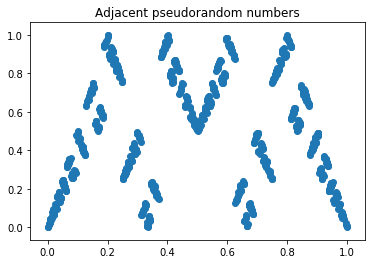

In [37]:
#run with a smaller subset
PlotAdjacentPseudos(additional_numbers[:1000])

The strange appearance of the plot is supported by the mixed results of statistical tests. It's a mixed bag. Overall, this generator doesn't seem that good.

1. Chi-square GOF: fail to reject null hypothesis of uniformity
2. Kolmogorov GOF: fail to reject null hypothesis of uniformity
3. Runs up and down: reject null hypothesis of independence
4. Runs above & below mean: fail to reject null hypothesis of independence
5. Autocorrelation: fail to reject null hypothesis of independence. (This is concordant with the plot of adjacent PRNs.)

Even though the statistical tests are a mixed bag, the standard normal deviates we generate do pass the K-S test.

In [38]:
#Uniformity - chi-square GOF
test_statistic,p_value=GoodnessOfFit(additional_numbers,10)
print(test_statistic,p_value)

4.164 0.9002904720024253


In [39]:
#Uniformity - Kolmogorov-Smirnov GOF
test_statistic,p_value=kstest(additional_numbers,'uniform')
print(test_statistic,p_value)

0.006494818719616213 0.7928150010391738


In [40]:
#Independence - runs up and down
num_of_runs,test_statistic,critical_value,result=RunsUpAndDown(additional_numbers)
print(num_of_runs,test_statistic,critical_value,result)

6239 -10.136018519144724 1.959963984540054 Reject null hypothesis of independence


In [41]:
#Independence - runs above and below mean
num_of_runs,test_statistic,critical_value,result=RunsAboveAndBelowMean(additional_numbers)
print(num_of_runs,test_statistic,critical_value,result)

4985 -0.3064263551336134 1.959963984540054 Fail to reject null hypothesis


In [42]:
#Autocorrelation
rho_estimate,test_statistic,critical_value,result=Autocorrelation(additional_numbers)
print(rho_estimate,test_statistic,critical_value,result)

-0.01863924798219241 -0.5169458078775203 1.959963984540054 Reject null hypothesis of independence


In [43]:
#generate standard normals
additional_numbers_1=additional_numbers[:int(NUM_OF_RANDOMS/2)]
additional_numbers_2=additional_numbers[int(NUM_OF_RANDOMS/2):]
U1,U2=additional_numbers_1,additional_numbers_2
Z1,Z2=GenerateStandardNormals(U1,U2)

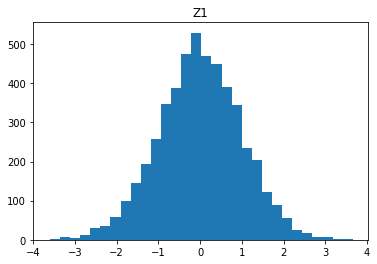

In [44]:
#standard deviates Z1
plt.hist(Z1,bins=30)
plt.title('Z1')
plt.xticks(np.arange(-4,5))
plt.show()

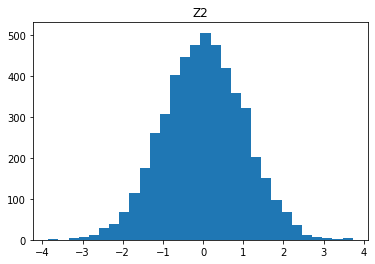

In [45]:
#standard deviates Z2
plt.hist(Z2,bins=30)
plt.title('Z2')
plt.xticks(np.arange(-4,5))
plt.show()

In [46]:
# We can check for normality of our deviates Z1 using the K-S test.
# p-value suggests we fail to reject null hypothesis.
# conclude that Z1 is approximately Normal.
test_statistic,p_value=kstest(Z1,'norm')
print(test_statistic,p_value)

0.011967970877387601 0.471013471614521


In [47]:
# We can check for normality of our deviates Z2 using the K-S test.
# FAIL TO REJECT NULL HYPOTHESIS THAT THE DEVIATES FOLLOW NORMAL DISTRIBUTION.
test_statistic,p_value=kstest(Z2,'norm')
print(test_statistic,p_value)

0.011538211945700483 0.5185434487063194


## Additional work Part B

Tausworthe's paper refers to another paper, "Primitive polynomials (mod 2)" by E.J. Watson, published in *Math. Comp* in 1962 (https://www.ams.org/journals/mcom/1962-16-079/S0025-5718-1962-0148256-1/S0025-5718-1962-0148256-1.pdf). There is a 100-order primitive polynomial in a table in this article, $x^{100}+x^{8}+x^{7}+x^2+1$. Let's use that.

In [48]:
# x^100 + x^8 + x^7 + x^2 + 1
def Tausworthe4(l=100,num=100):
    b=np.array(list(map(int,list(BinaryString(100)))))
    for i in range(100,l*num):
        new= np.logical_xor( np.logical_xor( b[i-92],b[i-93] ) , np.logical_xor(b[i-98],b[i-100])   )
        b=np.append(b,new)
    unifs=[]
    for j in range(num):
        number= b[j*l:(j+1)*l]
        number=np.char.mod("%i",number)
        number="".join(number)
        number=BinaryToDecimal(number)
        denominator=2**l
        unif=number/denominator
        unifs.append(unif)
    return np.array(unifs)

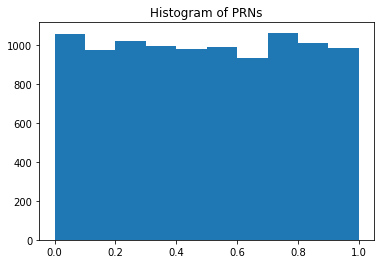

Check if PRNs are repeated
Plot adjacent PRNs on unit square


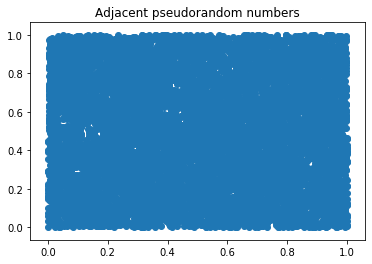

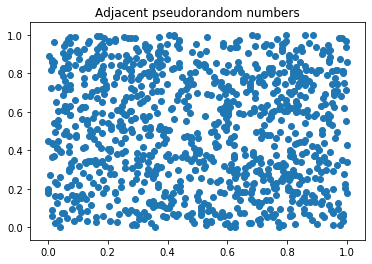

Uniformity - chi-square GOF
13.644 0.13556429362080363
Uniformity - Kolmogorov-Smirnov GOF 
0.00655513326252255 0.7834240902322136
Independence - runs up and down
6702 0.8459859450456283 1.959963984540054 Fail to reject null hypothesis
Independence - runs above and below mean
5086 1.7115543044939376 1.959963984540054 Fail to reject null hypothesis
Autocorrelation
-0.03823440444686188 -1.0604030331256975 1.959963984540054 Reject null hypothesis of independence


In [49]:
NUM_OF_RANDOMS=10000
additional_numbers_B = Tausworthe4(num=NUM_OF_RANDOMS)

#histogram of PRNs
plt.hist(additional_numbers_B)
plt.title('Histogram of PRNs')
plt.show()

#check if PRNs are repeated
print("Check if PRNs are repeated")
len(set(additional_numbers_B))==len(additional_numbers_B)

#plot adjacent PRNs on unit square to check for patterns
print("Plot adjacent PRNs on unit square")
PlotAdjacentPseudos(additional_numbers_B)
PlotAdjacentPseudos(additional_numbers_B[:1000])

#Uniformity - chi-square GOF
print("Uniformity - chi-square GOF")
test_statistic,p_value=GoodnessOfFit(additional_numbers_B,10)
print(test_statistic,p_value)

#Uniformity - Kolmogorov-Smirnov GOF 
print("Uniformity - Kolmogorov-Smirnov GOF ")
test_statistic,p_value=kstest(additional_numbers_B,'uniform')
print(test_statistic,p_value)

#Independence - runs up and down
print("Independence - runs up and down")
num_of_runs,test_statistic,critical_value,result=RunsUpAndDown(additional_numbers_B)
print(num_of_runs,test_statistic,critical_value,result)

#Independence - runs above and below mean'
print("Independence - runs above and below mean")
num_of_runs,test_statistic,critical_value,result=RunsAboveAndBelowMean(additional_numbers_B)
print(num_of_runs,test_statistic,critical_value,result)

#Autocorrelation
print("Autocorrelation")
rho_estimate,test_statistic,critical_value,result=Autocorrelation(additional_numbers_B)
print(rho_estimate,test_statistic,critical_value,result)

Interpretation of tests:

1. Chi-square GOF: fail to reject null hypothesis of uniformity
2. Kolmogorov GOF: fail to reject null hypothesis of uniformity
3. Runs up and down: fail to reject null hypothesis of independence
4. Runs above & below mean: fail to reject null hypothesis of independence
5. Autocorrelation: reject null hypothesis of independence. (Again, we see that similar to implementation 1, the Tausworthe generator we have implemented performs poorly on autocorrelation even though it 'passes' all the other tests.)

**Future work** (note: for conclusions, please refer to *Findings/Conclusions* in the main section of the report, since this section follows additional content that is above and beyond the project specifications)

1. Generalize the chi-squared test to higher-dimensions. Run the 'serial test' as described by Law (2015) which is a test for $d$-dimensional unfiormity. The sequence of PRNs may be partitioned into nonoverlapping $d$-tuples that should be i.i.d. random vectors distributed uniformly on the $d$-dimensional unit hypercube.

2. Try different implementations of Tausworthe using other polynomials.

3. Combine generators!